In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

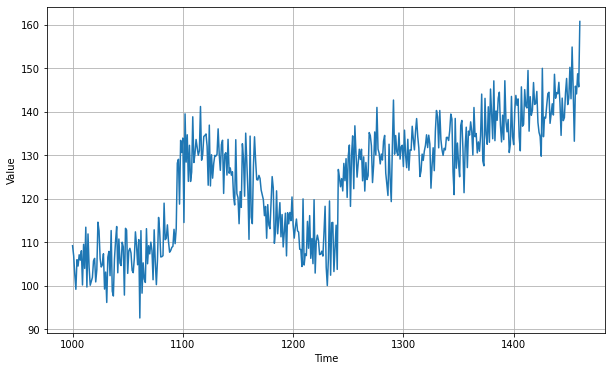

In [5]:
plt.figure(figsize=(16, 6))
plot_series(time_valid, x_valid)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


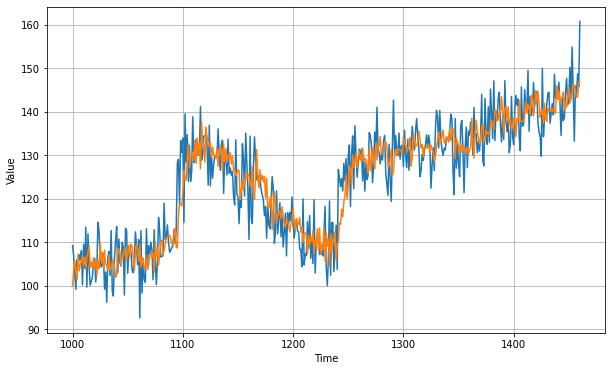

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.723417

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 13ms/step - loss: 746.8434
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 354.9871
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 153.8930
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 88.5603
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 73.0067
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 70.3109
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 69.9965
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 70.0179
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 69.4430
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 70.2021
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 69.6532
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 69.2518
Epoch 13/100
31/31 [=

31/31 [==============================] - 0s 4ms/step - loss: 736.4749


(1e-08, 0.001, 0.0, 300.0)

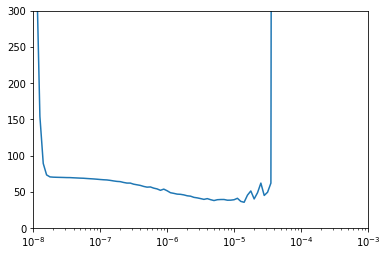

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [12]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 13ms/step - loss: 589.0619
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 83.0883
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 62.0819
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 68.9496
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 57.1015
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 48.6874
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 47.2201
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 51.3740
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 48.3370
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 43.6721
Epoch 11/500
31/31 [==============================] - 0s 5ms/step - loss: 43.3864
Epoch 12/500
31/31 [==============================] - 0s 4ms/step - loss: 39.8659
Epoch 13/500
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 42.3173
Epoch 101/500
31/31 [==============================] - 0s 4ms/step - loss: 35.6454
Epoch 102/500
31/31 [==============================] - 0s 4ms/step - loss: 38.4871
Epoch 103/500
31/31 [==============================] - 0s 4ms/step - loss: 35.9530
Epoch 104/500
31/31 [==============================] - 0s 4ms/step - loss: 37.8933
Epoch 105/500
31/31 [==============================] - 0s 4ms/step - loss: 36.0502
Epoch 106/500
31/31 [==============================] - 0s 4ms/step - loss: 32.6738
Epoch 107/500
31/31 [==============================] - 0s 4ms/step - loss: 35.8789
Epoch 108/500
31/31 [==============================] - 0s 4ms/step - loss: 34.0527
Epoch 109/500
31/31 [==============================] - 0s 4ms/step - loss: 33.8703
Epoch 110/500
31/31 [==============================] - 0s 4ms/step - loss: 34.6490
Epoch 111/500
31/31 [==============================] - 0s 4ms/step - loss: 38.8984
Epoch 112/500
31/3

31/31 [==============================] - 0s 4ms/step - loss: 35.7024
Epoch 199/500
31/31 [==============================] - 0s 5ms/step - loss: 34.6543
Epoch 200/500
31/31 [==============================] - 0s 5ms/step - loss: 33.7958
Epoch 201/500
31/31 [==============================] - 0s 5ms/step - loss: 34.6251
Epoch 202/500
31/31 [==============================] - 0s 5ms/step - loss: 33.7937
Epoch 203/500
31/31 [==============================] - 0s 4ms/step - loss: 33.2826
Epoch 204/500
31/31 [==============================] - 0s 5ms/step - loss: 39.9789
Epoch 205/500
31/31 [==============================] - 0s 4ms/step - loss: 33.3581
Epoch 206/500
31/31 [==============================] - ETA: 2s - loss: 28.84 - 0s 4ms/step - loss: 33.5461
Epoch 207/500
31/31 [==============================] - 0s 4ms/step - loss: 34.0507
Epoch 208/500
31/31 [==============================] - 0s 5ms/step - loss: 32.9631
Epoch 209/500
31/31 [==============================] - 0s 4ms/step - loss: 34

31/31 [==============================] - 0s 4ms/step - loss: 34.2902
Epoch 297/500
31/31 [==============================] - 0s 4ms/step - loss: 39.5246
Epoch 298/500
31/31 [==============================] - 0s 4ms/step - loss: 34.8790
Epoch 299/500
31/31 [==============================] - 0s 4ms/step - loss: 32.1037
Epoch 300/500
31/31 [==============================] - 0s 5ms/step - loss: 36.3742
Epoch 301/500
31/31 [==============================] - 0s 5ms/step - loss: 40.2138
Epoch 302/500
31/31 [==============================] - 0s 5ms/step - loss: 39.7950
Epoch 303/500
31/31 [==============================] - 0s 5ms/step - loss: 33.0859
Epoch 304/500
31/31 [==============================] - 0s 5ms/step - loss: 38.6446
Epoch 305/500
31/31 [==============================] - 0s 4ms/step - loss: 36.0319
Epoch 306/500
31/31 [==============================] - 0s 5ms/step - loss: 33.9632
Epoch 307/500
31/31 [==============================] - 0s 5ms/step - loss: 33.8706
Epoch 308/500
31/3

31/31 [==============================] - 0s 5ms/step - loss: 34.8542
Epoch 395/500
31/31 [==============================] - 0s 4ms/step - loss: 34.1372
Epoch 396/500
31/31 [==============================] - 0s 5ms/step - loss: 31.8095
Epoch 397/500
31/31 [==============================] - 0s 4ms/step - loss: 35.6690
Epoch 398/500
31/31 [==============================] - 0s 5ms/step - loss: 35.5151
Epoch 399/500
31/31 [==============================] - 0s 5ms/step - loss: 35.7597
Epoch 400/500
31/31 [==============================] - 0s 4ms/step - loss: 32.2688
Epoch 401/500
31/31 [==============================] - 0s 4ms/step - loss: 33.2358
Epoch 402/500
31/31 [==============================] - 0s 5ms/step - loss: 35.6025
Epoch 403/500
31/31 [==============================] - 0s 5ms/step - loss: 44.4889
Epoch 404/500
31/31 [==============================] - 0s 5ms/step - loss: 36.4848
Epoch 405/500
31/31 [==============================] - 0s 4ms/step - loss: 35.1091
Epoch 406/500
31/3

31/31 [==============================] - 0s 4ms/step - loss: 34.7409
Epoch 493/500
31/31 [==============================] - 0s 4ms/step - loss: 33.4448
Epoch 494/500
31/31 [==============================] - 0s 4ms/step - loss: 33.1241
Epoch 495/500
31/31 [==============================] - 0s 4ms/step - loss: 33.4604
Epoch 496/500
31/31 [==============================] - 0s 5ms/step - loss: 31.3258
Epoch 497/500
31/31 [==============================] - 0s 5ms/step - loss: 34.8025
Epoch 498/500
31/31 [==============================] - 0s 5ms/step - loss: 33.4592
Epoch 499/500
31/31 [==============================] - 0s 6ms/step - loss: 38.2554
Epoch 500/500
31/31 [==============================] - 0s 6ms/step - loss: 38.2678


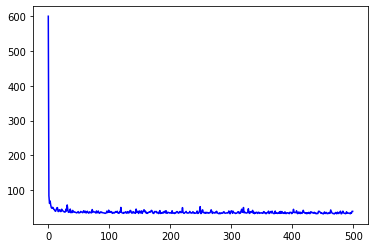

In [13]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

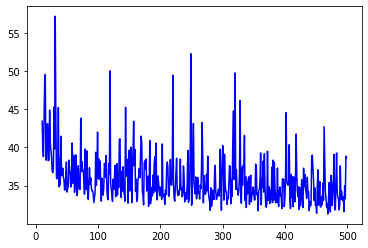

In [14]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
# print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

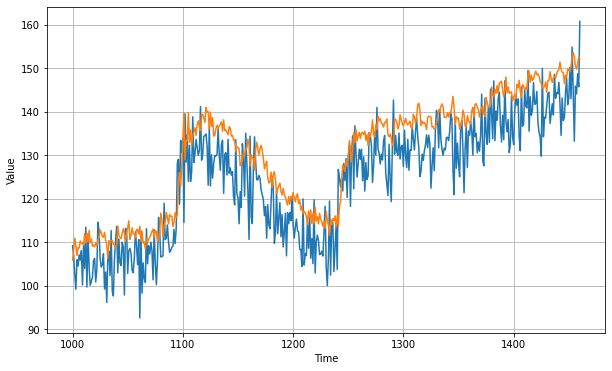

In [15]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.8267436